In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [2]:
#Contans
pi = np.pi
kb = 8.617333262145e-5  # Boltzmann constant in eV/K
T = 600 + 273.15        # Temperature in Kelvin

In [65]:
# Helper functions
def D_Coeff(D_0, E_m, T):
    return D_0 * np.exp(-E_m / (kb * T))

def log_factor(r_0, r_L, eps=1e-10):
    logt = np.log(8 * r_L / r_0)
    r = r_0 * logt
    return 1 / r if r > eps else eps

def compute_j_L_i(C_Th_i, D_Th_i, r_0, r_L, eps=1e-10):
    log_fact = log_factor(r_0, r_L)
    num = D_Th_i * C_Th_i
    return log_fact * num 

def compute_j_ii(C_Th_i, C_O_i, D_Th_i, D_O_i, eta, Z_2_Th = 6, Z_2_O = 6, eps=1e-10):
    
    numerator = Z_2_Th * D_Th_i * (C_Th_i**2) * Z_2_O * D_O_i * (C_O_i**2)
    denominator = 2 * Z_2_Th * D_Th_i * (C_Th_i**2) + Z_2_O * D_O_i * (C_O_i**2)
    
    return eta * numerator / denominator 

def loop_life_time_term(N_L, R_L, alpha, beta, k_lf):
    pro = np.power(N_L, alpha) * np.power(R_L, beta)
    return k_lf * np.power(N_L, alpha) * np.power(R_L, beta)


In [101]:
# ODE system
def ODE_system(t, y, params):
    C_Th_v, C_O_v, C_Th_i, C_O_i, N_L, R_L = y

    G_Th_v = params['G_Th_v']
    G_O_v  = params['G_O_v']
    G_Th_i = params['G_Th_i']
    G_O_i  = params['G_O_i']
    a     = params['a']
    Omega_0 = (a**3) / 12
    D_Th_i = params['D_Th_i']
    D_O_i  = params['D_O_i']
    D_Th_v = params['D_Th_v']
    D_O_v  = params['D_O_v']
    r0     = params['r0']
    L = params['L']
    b = a / np.sqrt(3)
    alpha = params['alpha']
    beta = params['beta']
    k_lf = params['k_lf']
    eta =  Omega_0 / a**2
    st   = 2 * pi * R_L * N_L

     
    j_L_i = 0
    j_ii = 0
    
    if C_Th_i != 0 or C_O_i != 0:
        j_L_i = compute_j_L_i(C_Th_i, D_Th_i, r0, R_L)
        j_ii  = compute_j_ii(C_Th_i, C_O_i, D_Th_i, D_O_i, eta)
    
    tau = loop_life_time_term(N_L, R_L, alpha, beta, k_lf)
    
    k_Th = eta * (48 * D_Th_i + 48 * D_Th_i)
    k_O  = eta * (36 * D_O_i + 24 * D_O_i)

    c_lamalle = 12/(L**2)

    
    dc = np.zeros(6)
    
    #R_L evolution
    
    dc[5] = 3 * Omega_0 * 2 * pi * r0 * j_L_i / b

    dc[4] =  j_ii 

    if tau != 0 :
        dc[4] -=  N_L / tau
    

    
    if dc[5] < 0 and R_L <= 2*r0:
        dc[5] = 0

    if dc[4] < 0 and N_L <= 0:
        dc[4] = 0

    dc[0] = G_Th_v - k_Th * C_Th_v * C_Th_i # - c_lamalle * D_Th_v * C_Th_v (neglected)
    dc[1] = G_O_v  - k_O  * C_O_v  * C_O_i  - c_lamalle * D_O_v * C_O_v
    dc[2] = G_Th_i - k_Th * C_Th_i * C_Th_v - c_lamalle * D_Th_i * C_Th_i  - j_L_i * pi * r0 * st - j_ii
    dc[3] = G_O_i  - k_O  * C_O_i  * C_O_v  - c_lamalle * D_O_i * C_O_i - 2 * j_L_i * pi * r0 * st - 2 * j_ii

    return dc


In [102]:

def interactive_plots(results, G_0):
    time = results['time']
    dose = time * G_0

    # Ce Concentrations
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=time, y=results['C_Th_v'],
                              mode='lines', name='C_Th_v'))
    fig1.add_trace(go.Scatter(x=time, y=results['C_Th_i'],
                              mode='lines', name='C_Th_i'))
    fig1.update_layout(title="Vacancy Concentrations",
                       xaxis=dict(title="Time [s]", type="log",  exponentformat='power'),
                       yaxis=dict(title="Concentration [cm<sup>-3</sup>]", type="log", exponentformat='power'),
                       width=600, height=500)
    fig1.show()

    # O Concentrations
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=time, y=results['C_O_v'],
                              mode='lines', name='C_O_v'))
    fig2.add_trace(go.Scatter(x=time, y=results['C_O_i'],
                              mode='lines', name='C_O_i'))
    fig2.update_layout(title="Interstitial Concentrations",
                       xaxis=dict(title="Time [s]", type="log", exponentformat='power'),
                       yaxis=dict(title="Concentration [cm<sup>-3</sup>]", type="log", exponentformat='power'),
                       width=600, height=500)
    fig2.show()

    # Loop density
    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=dose, y=results['N_L']*1e-16,
                              mode='lines', name='N_L'))
    fig3.update_layout(title="Dislocation Loop Density",
                       xaxis=dict(title="Dose [dpa]"),
                       yaxis=dict(title="Loop Density [ 10<sup>16</sup> cm<sup>-3</sup>] "),
                       width=600, height=500)
    fig3.show()

    # Loop radius
    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(x=dose, y=results['R_L']*1e7,
                              mode='lines', name='R_L'))
    fig4.update_layout(title="Dislocation Loop Radius",
                       xaxis=dict(title="Dose [dpa]"),
                       yaxis=dict(title="Loop Radius [nm]"),
                       width=600, height=500)
    fig4.show()


In [103]:
#Parameters
a = 561e-10   # cm
N = 12 
Omega_0 = (a**3) / N
b = a / np.sqrt(3)

L = 100e-7 # Lamallae thickness cm

alpha = 1
beta = 1

D_0_Th_v, D_0_Th_i, D_0_O_v, D_0_O_i = 0.65, 0.01, 0.02, 0.01

E_m_Th_v, E_m_Th_i, E_m_O_v, E_m_O_i = 5.0, 2.6, 1.18, 0.836

# Dose rate dpa/s
G_Th_0 = 0.39e-3  
G_O_0 = 1.54e-3

# Dose rato to dpa/(s*cm^-3)

G_Th = G_Th_0 / Omega_0 
G_O  = G_O_0 / Omega_0
r0 = 180.4e-10 #cm

k_lf = 2

params = {
    'G_Th_v': G_Th, 'G_O_v': G_O,
    'G_Th_i': G_Th, 'G_O_i': G_O,
    'a': a, 
    'D_Th_i': D_Coeff(D_0_Th_i, E_m_Th_i, T),
    'D_Th_v': D_Coeff(D_0_Th_v, E_m_Th_v, T),
    'D_O_i':  D_Coeff(D_0_O_i,  E_m_O_i, T),
    'D_O_v':  D_Coeff(D_0_O_v,  E_m_O_v, T),
    'r0': r0,
    'L': L,
    'alpha': alpha,
    'beta': beta,
    'k_lf': k_lf
}

print(f"D_Ce_i = {params['D_Th_i']:.3e} cm^2/s")
print(f"D_Ce_v = {params['D_Th_v']:.3e} cm^2/s")
print(f"D_O_i  = {params['D_O_i']:.3e} cm^2/s")
print(f"D_O_v  = {params['D_O_v']:.3e} cm^2/s")
print(f"G_Ce   = {params['G_Th_v']:.3e} dpa/(s*cm^3)")
print(f"G_O   = {params['G_O_v']:.3e} dpa/(s*cm^3)")


D_Ce_i = 9.839e-18 cm^2/s
D_Ce_v = 8.978e-30 cm^2/s
D_O_i  = 1.495e-07 cm^2/s
D_O_v  = 3.091e-09 cm^2/s
G_Ce   = 2.651e+19 dpa/(s*cm^3)
G_O   = 1.047e+20 dpa/(s*cm^3)


In [104]:
# Initial conditions
t0 = 0.0001149
y0 = [0,0,0,0,0, 2*pi*a**2]

#Damage rate dpa/s
G_0 = 1.9e-3

# Total time from total dose
dmg = 3.0   # dpa
t_end = dmg / G_0
t_span = (t0, t_end)
t_eval = np.linspace(t0, t_end, 1000)

solution = solve_ivp(ODE_system, method='BDF', t_span=t_span, y0=y0,
                     args=(params,), t_eval=t_eval)


In [105]:
# Collect results and plot
results = pd.DataFrame(solution.y.T,
                       columns=['C_Th_v','C_O_v','C_Th_i','C_O_i','N_L','R_L'])
results['time'] = solution.t


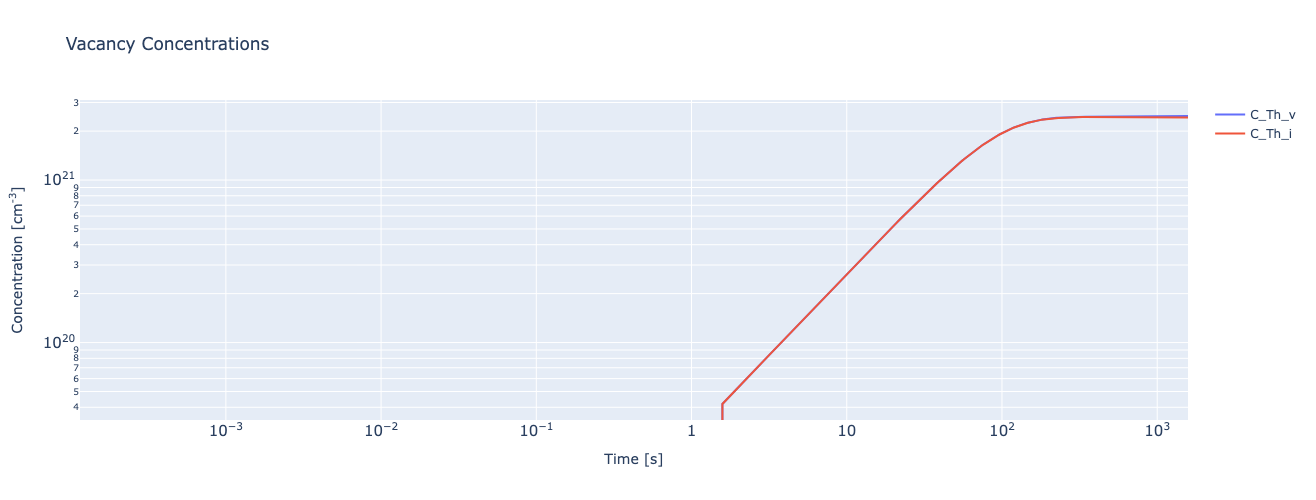

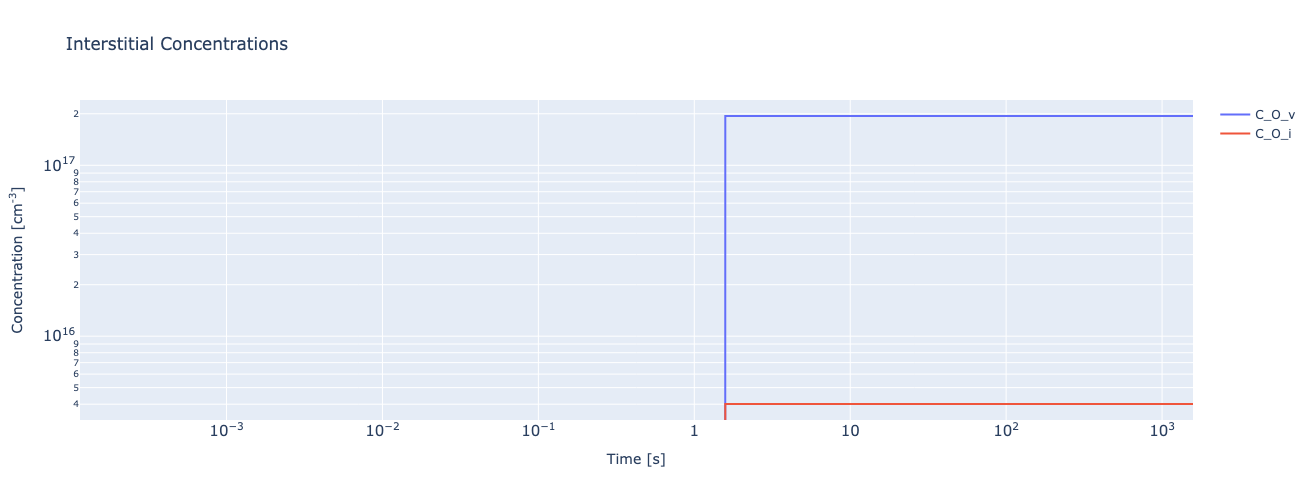

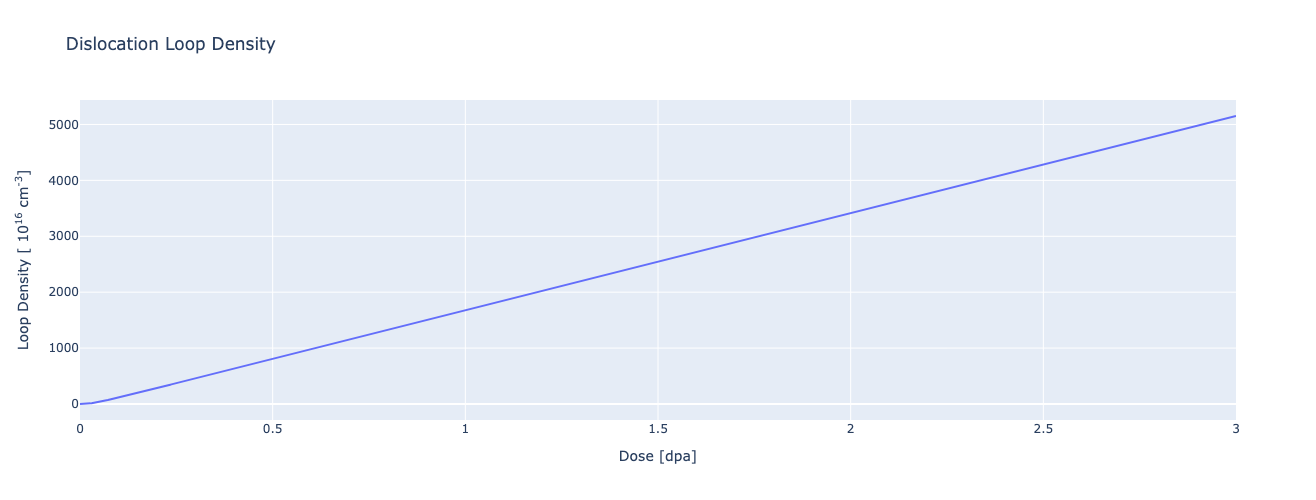

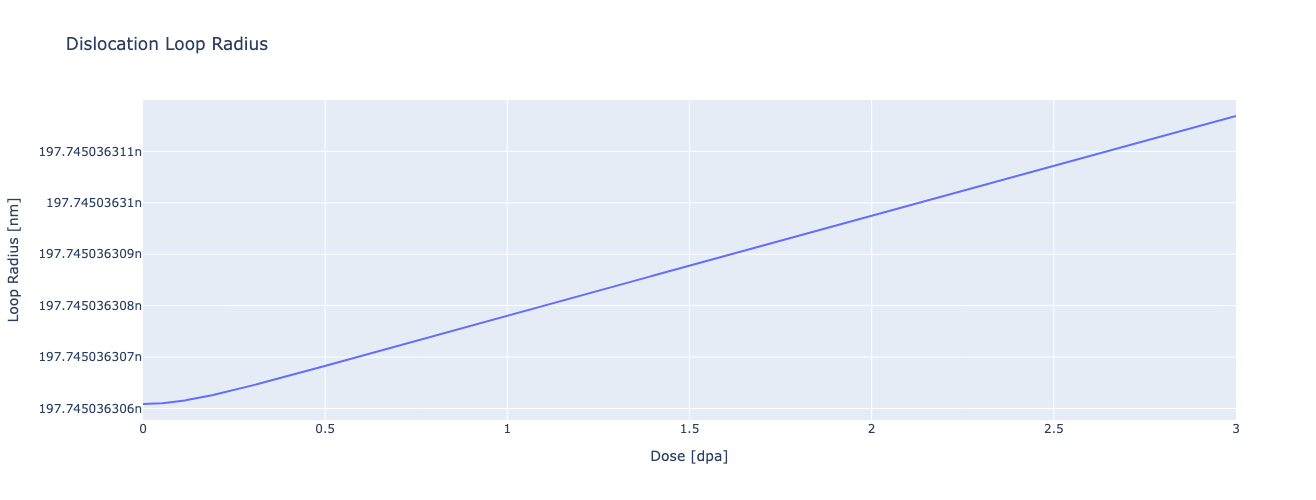

In [106]:
interactive_plots(results, G_0)